In [1]:
%cd ~/user_data/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base
%pwd

/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base


'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [2]:
import os
import random
import numpy as np
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import CocoDetection
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from PIL import Image
import cv2
from pycocotools.coco import COCO
from transformers import pipeline
from transformers import Owlv2ImageProcessor, Owlv2Processor, Owlv2ForObjectDetection
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
import pandas as pd
import glob

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

/home/DREXEL/jw3897/miniconda3/envs/owlvit/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cuda


In [4]:
val_image_dir = r'/mnt/active_storage/Joe/coco_set/val2017/images'
val_annotation_path = r'/mnt/active_storage/Joe/coco_set/val2017/annotations/ovd_ins_val2017_b.json'

coco_val_dataset = CocoDetection(
    root=val_image_dir, 
    annFile=val_annotation_path,
)

loading annotations into memory...
Done (t=0.47s)
creating index...
index created!


In [5]:
print(len(coco_val_dataset))

4533


In [6]:
ovd_base_image_ids = []
for item in coco_val_dataset:
    ovd_base_image_ids.append(item[1][0]['image_id'])

print(len(ovd_base_image_ids))

4533


In [7]:
# image_filenames = os.listdir(val_image_dir)
# image_filenames.sort()

# image_ids = []
# for image_filename in image_filenames:
#     image_id = image_filename.split('.')[0].lstrip('0')
#     image_ids.append(image_id)

In [8]:
category_names = ['person', 'bicycle', 'car', 'motorcycle', 'train', 'truck', \
    'boat', 'bench', 'bird', 'horse', 'sheep', 'bear', 'zebra', 'giraffe', \
    'backpack', 'handbag', 'suitcase', 'frisbee', 'skis', 'kite', 'surfboard', \
    'bottle', 'fork', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', \
    'broccoli', 'carrot', 'pizza', 'donut', 'chair', 'bed', 'toilet', 'tv', \
    'laptop', 'mouse', 'remote', 'microwave', 'oven', 'toaster', \
    'refrigerator', 'book', 'clock', 'vase', 'toothbrush']

In [9]:
category_ids = coco_val_dataset.coco.loadCats(coco_val_dataset.coco.getCatIds())

targets = []
target_boxes = []
target_labels = []

for idx, image_tuple in enumerate(coco_val_dataset):
    image = image_tuple[0]
    annotations = image_tuple[1]
    
    for annotation in annotations:
        label_name = [category['name'] for category in category_ids if category['id'] == annotation['category_id']][0]

        try:
            label = category_names.index(label_name)
        except ValueError as e:
            # If the annotation is not part of the base categories, skip it
            continue

        # xmin, ymin, width, height -> xmin, ymin, xmax, ymax
        box = annotation['bbox']
        bbox = []
        bbox.append(int(round(box[0])))
        bbox.append(int(round(box[1])))
        bbox.append(int(round(box[0] + box[2])))
        bbox.append(int(round(box[1] + box[3])))

        target_boxes.append(bbox)
        target_labels.append(label)

    target_boxes = torch.tensor(target_boxes, dtype=torch.int)
    target_labels = torch.tensor(target_labels, dtype=torch.int)

    target_image_dict = {
        'image_id': ovd_base_image_ids[idx],
        'boxes': target_boxes,
        'labels': target_labels
    }

    targets.append(target_image_dict)

    # Clear boxes and labels
    target_boxes = []
    target_labels = []

# Evaluation Code

In [10]:
%pwd

'/mnt/researchfiles/ECE IMAPLE/cluster_data/user_data/jw3897/research/git/zero-shot-object-detection/frontend_owlvit/owlv2_coco_base'

In [12]:
# prediction_files = glob.glob(r'./grouped_predictions/*.parquet')

# predictions_dfs = []

# for prediction_file in glob.glob(r'./grouped_predictions/*.parquet'):
#     predictions_dfs.append(pd.read_parquet(prediction_file))

# predictions_df_total = pd.concat(predictions_dfs)

# predictions_df_total.sort_values(by=['image_id'], inplace=True)
# predictions_df_total.rename(columns={'label_score': 'score'}, inplace=True)

# predictions_df_total.to_parquet(r'./owlv2_coco_base_predictions.parquet')

predictions_df_total = pd.read_parquet(r'./owlv2_coco_base_predictions.parquet')

In [ ]:
objectness_threshold = 0.2
score_threshold = 0.1

predictions_likely_objects = predictions_df_total[predictions_df_total['objectness_score'] >= objectness_threshold].sort_values('objectness_score', ascending=False).groupby('image_id').head(100).sort_values('image_id')
predictions_likely_objects = predictions_likely_objects.loc[predictions_likely_objects['image_id'].isin(ovd_base_image_ids)]

known_objects = predictions_likely_objects[predictions_likely_objects['score'] >= score_threshold]
unknown_objects = predictions_likely_objects[predictions_likely_objects['score'] <= score_threshold]

display(known_objects)
display(unknown_objects)

print(f"Number of Known Annotations: {len(known_objects)}. Number of Unknown Annotations: {len(unknown_objects)}")

In [14]:
# image_id | [known object labels] | [known object locations] | unknown object location

In [15]:
predictions_dict = known_objects.to_dict('records')

In [16]:
preds = []
pred_boxes = []
pred_scores = []
pred_objectness_scores = []
pred_labels = []

current_img_id = predictions_dict[0]['image_id']
for prediction in predictions_dict:
    # If on a new image...
    if prediction['image_id'] != current_img_id:
        # Convert boxes, scores, and labels to tensors
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
        pred_scores = torch.tensor(pred_scores, dtype=torch.float)
        pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
        pred_labels = torch.tensor(pred_labels, dtype=torch.int)

        # Create the dict for preds
        pred_image_dict = {
            'image_id': current_img_id,
            'boxes': pred_boxes,
            'scores': pred_scores,
            'objectness_scores': pred_objectness_scores,
            'labels': pred_labels
        }

        preds.append(pred_image_dict)

        # Clear boxes, scores, and labels for the new image
        pred_boxes = []
        pred_scores = []
        pred_objectness_scores = []
        pred_labels = []

        # Set new current image id
        current_img_id = prediction['image_id']

    bbox = []
    bbox.append(prediction['xmin'])
    bbox.append(prediction['ymin'])
    bbox.append(prediction['xmax'])
    bbox.append(prediction['ymax'])

    pred_boxes.append(bbox)
    pred_scores.append(prediction['score'])
    pred_objectness_scores.append(prediction['objectness_score'])
    pred_labels.append(category_names.index(prediction['label']))

# Capture the predictions for the last image
pred_boxes = torch.tensor(pred_boxes, dtype=torch.int)
pred_scores = torch.tensor(pred_scores, dtype=torch.float)
pred_objectness_scores = torch.tensor(pred_objectness_scores, dtype=torch.float)
pred_labels = torch.tensor(pred_labels, dtype=torch.int)

# Create the dict for preds
pred_image_dict = {
    'image_id': current_img_id,
    'boxes': pred_boxes,
    'scores': pred_scores,
    'objectness_scores': pred_objectness_scores,
    'labels': pred_labels
}

preds.append(pred_image_dict)

In [17]:
print(len(preds))

4346


In [18]:
if len(preds) < len(coco_val_dataset):
    pred_image_ids = np.unique([pred['image_id'] for pred in preds])
    missing_ids = list(set(ovd_base_image_ids) - set(pred_image_ids))
    missing_ids.sort()

    for missing_id in missing_ids:
        missing_id_dict = {
            'image_id': missing_id,
            'boxes': torch.tensor([], dtype=torch.int),
            'scores': torch.tensor([], dtype=torch.float),
            'objectness_scores': torch.tensor([], dtype=torch.float),
            'labels': torch.tensor([], dtype=torch.int),
        }
        preds.insert(ovd_base_image_ids.index(missing_id), missing_id_dict)

In [19]:
assert len(preds) == len(coco_val_dataset)
for idx in range (len(preds)):
    assert preds[idx]['image_id'] == ovd_base_image_ids[idx]

In [20]:
for idx in range(len(targets)):
    assert targets[idx]['image_id'] == preds[idx]['image_id']

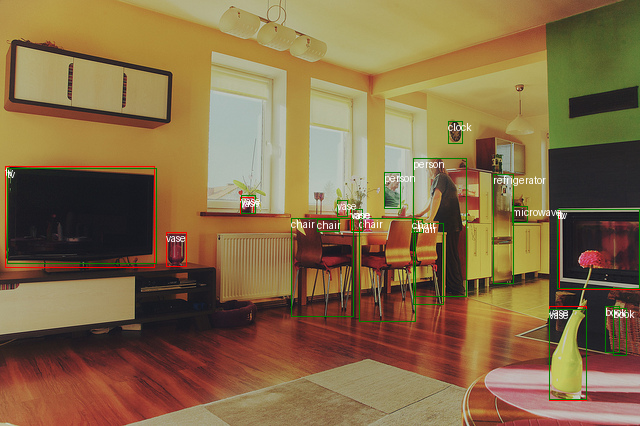

In [21]:
# Visualize some preds and targets
from PIL import ImageDraw

index = 0

visualized_image = coco_val_dataset[index][0].copy()

draw = ImageDraw.Draw(visualized_image)

for box, label in zip(preds[index]['boxes'], preds[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='red')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

for box, label in zip(targets[index]['boxes'], targets[index]['labels']):
    draw.rectangle(xy=((box[0], box[1]), (box[2], box[3])), outline='green')
    draw.text(xy=(box[0], box[1]), text=category_names[label.item()])

display(visualized_image)

In [22]:
metric = MeanAveragePrecision(
    box_format='xyxy',
    iou_type='bbox',
    iou_thresholds=None, # Defaults to trying from 0.5 -> 0.95 in steps of 0.05 
    rec_thresholds=None,
    max_detection_thresholds=None, # Uses [1, 10, 100]
    class_metrics=False,
    extended_summary=False, # This way, we can see the ious and scores calculated
    average='macro',
    backend='pycocotools'
)

metric.update(preds, targets)

In [23]:
computed_metric = metric.compute()

In [24]:
print(f"Objectness Threshold: {objectness_threshold}; Score Threshold: {score_threshold}")
print(f"mAP: {round(computed_metric['map'].item(), 4):.4f}\nKnown: {len(known_objects)}\nUnknown: {len(unknown_objects)}")

Objectness Threshold: 0.2; Score Threshold: 0.2
mAP: 0.3783
Known: 27439
Unknown: 33519


In [25]:
# image_id | [known object labels] | [known object locations] | unknown object location

In [ ]:
final_df = pd.DataFrame(columns=['image_id', 'known_object_labels', 'known_object_bboxes', 'unknown_object_location', 'unknown_object_bbox'])

merged_df = pd.merge(predictions_likely_objects, known_objects)

In [ ]:
dfs = []

#unknown_object = unknown_objects.iloc[0]
for idx, unknown_object in unknown_objects.iterrows():
    # print(unknown_object)
    # input()
    known_objects_in_image = known_objects[known_objects['image_id'] == unknown_object['image_id']]
    unknown_object_dict = {
        'image_id': unknown_object['image_id'],
    }

    known_object_labels = []
    known_object_bboxes = []
    for idx, known_object in known_objects_in_image.iterrows():
        known_object_labels.append(known_object['label'])
        known_object_bboxes.append([known_object['xmin'], known_object['ymin'], known_object['xmax'], known_object['ymax']])

    unknown_object_bbox = [unknown_object['xmin'], unknown_object['ymin'], unknown_object['xmax'], unknown_object['ymax']]

    unknown_object_dict['known_object_labels'] = known_object_labels
    unknown_object_dict['known_object_bboxes'] = known_object_bboxes
    unknown_object_dict['unknown_object_bbox'] = unknown_object_bbox
    unknown_object_dict['unknown_score'] = unknown_object['score']

    df = pd.DataFrame(columns=['image_id', 'known_object_labels', 'known_object_bboxes', 'unknown_object_bbox', 'unknown_object_score'])

    df.loc[0] = [unknown_object_dict['image_id'], unknown_object_dict['known_object_labels'], unknown_object_dict['known_object_bboxes'], unknown_object_dict['unknown_object_bbox'], unknown_object_dict['unknown_score']]

    dfs.append(df)


final_df = pd.concat(dfs)

In [100]:
display(final_df)

,image_id,known_object_labels,known_object_bboxes,unknown_object_bbox,unknown_object_score
0,139,"[vase, vase, tv, vase, tv, vase]","[[350.8769226074219, 209.57444763183594, 362.1...","[555.129150390625, 290.8760681152344, 577.7758...",0.048069
0,139,"[vase, vase, tv, vase, tv, vase]","[[350.8769226074219, 209.57444763183594, 362.1...","[466.03692626953125, 354.44500732421875, 637.8...",0.019408
0,139,"[vase, vase, tv, vase, tv, vase]","[[350.8769226074219, 209.57444763183594, 362.1...","[337.8964538574219, 176.37796020507812, 381.80...",0.016014
0,139,"[vase, vase, tv, vase, tv, vase]","[[350.8769226074219, 209.57444763183594, 362.1...","[217.28807067871094, 232.3456573486328, 296.70...",0.002407
0,139,"[vase, vase, tv, vase, tv, vase]","[[350.8769226074219, 209.57444763183594, 362.1...","[218.589599609375, 0.23985624313354492, 320.86...",0.010626
...,...,...,...,...,...
0,581781,"[banana, banana, banana, banana, banana, banan...","[[463.3008117675781, 422.8099365234375, 592.42...","[296.6373596191406, 30.675127029418945, 337.89...",0.012246
0,581781,"[banana, banana, banana, banana, banana, banan...","[[463.3008117675781, 422.8099365234375, 592.42...","[388.9864807128906, 123.0881118774414, 447.452...",0.030917
0,581781,"[banana, banana, banana, banana, banana, banan...","[[463.3008117675781, 422.8099365234375, 592.42...","[281.27337646484375, 434.9082946777344, 371.02...",0.176230
0,581781,"[banana, banana, banana, banana, banana, banan...","[[463.3008117675781, 422.8099365234375, 592.42...","[289.3376770019531, 123.22624969482422, 324.08...",0.019083


In [ ]:
final_df.to_parquet(r'/mnt/archive/owlvit_results/coco_base_prepared_for_adam.parquet')